# TNT Loop-Bridge: LAOS

## Objectives

- Fit TNT Loop-Bridge model to Large Amplitude Oscillatory Shear (LAOS) data
- Understand bridge fraction oscillation at large strain
- Analyze nonlinear Lissajous curves and higher harmonics
- Quantify strain-dependent modulus via Fourier analysis
- Perform Bayesian inference for parameter uncertainty

## Setup

In [ ]:
import os
import sys
import time

# CI mode for automated testing
CI_MODE = os.environ.get("CI_MODE", "0") == "1"

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax

import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from rheojax.core.jax_config import safe_import_jax
jax, jnp = safe_import_jax()
from rheojax.core.jax_config import verify_float64
verify_float64()

from rheojax.models.tnt import TNTLoopBridge

sys.path.insert(0, os.path.join("..", "utils"))
from tnt_tutorial_utils import (
    load_ml_ikh_flow_curve,
    load_pnas_startup,
    load_laponite_relaxation,
    load_ml_ikh_creep,
    load_epstein_saos,
    load_pnas_laos,
    compute_fit_quality,
    print_convergence_summary,
    print_parameter_comparison,
    save_tnt_results,
    get_tnt_loop_bridge_param_names,
    plot_loop_bridge_fraction,
    plot_bell_nu_sweep,
    compute_maxwell_moduli,
    compute_bell_effective_lifetime,
    print_nu_interpretation,
)

param_names = get_tnt_loop_bridge_param_names()

## Theory: LAOS Response

### Physical Picture

In Large Amplitude Oscillatory Shear (LAOS):
- Strain amplitude is large (typically > 10%)
- Nonlinear response regime
- Bridge fraction oscillates with the strain cycle
- Force-enhanced detachment becomes significant

### Governing Equations

**Applied Strain:**
```
γ(t) = γ₀ * sin(ω * t)
γ̇(t) = γ₀ * ω * cos(ω * t)
```

**Bridge Fraction Evolution:**
```
df_B/dt = (1 - f_B)/tau_a - f_B * exp(nu * |γ̇(t)| * tau_b) / tau_b
```

At large γ₀:
- Peak shear rate: γ̇_max = γ₀ * ω
- Bell factor oscillates: exp(nu * γ₀ * ω * tau_b * |cos(ω*t)|)
- f_B decreases during high shear rate phases
- f_B recovers during low shear rate phases

**Stress Response (Maxwell backbone):**
```
σ(t) = f_B(t) * G * γ_e(t)
```

**Nonlinear Features:**
1. **Harmonic distortion**: σ(t) contains odd harmonics (3ω, 5ω, ...)
2. **Lissajous distortion**: σ vs γ curve deviates from ellipse
3. **Strain softening**: Effective modulus decreases at large strain
4. **Intracycle dynamics**: f_B oscillates within each cycle

### Fourier Analysis

**Stress Decomposition:**
```
σ(t) = Σ [G'_n * sin(n*ω*t) + G''_n * cos(n*ω*t)]
```

**First Harmonic (n=1):**
- G'₁: Elastic modulus (strain-dependent)
- G''₁: Viscous modulus (strain-dependent)

**Higher Harmonics (n=3,5,...):**
- Quantify nonlinearity
- G'₃/G'₁: Relative nonlinear contribution

### Strain Dependence

As γ₀ increases:
- Average f_B decreases → G'₁ decreases (strain softening)
- Higher harmonics increase → more distortion
- Lissajous curves become non-elliptical

## Load LAOS Data

Data points: 200
Time range: 5.27e-03 - 6.60e+01 s
Strain amplitude γ₀: 0.5120
Frequency ω: 1.00 rad/s
Peak shear rate: 0.5120 1/s
Stress range: -17.27 - 20.43 Pa


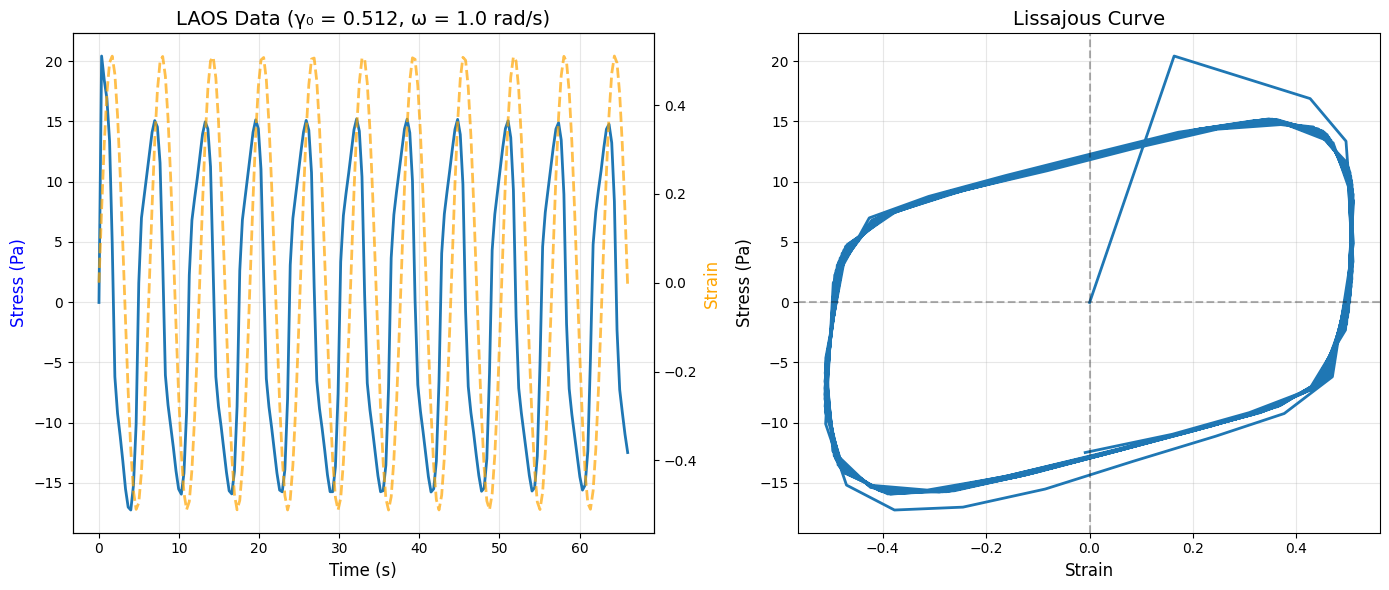

In [2]:
time_data, strain, stress = load_pnas_laos(omega=1.0, strain_amplitude_index=5)

# Extract strain amplitude
gamma_0 = float(np.max(np.abs(strain)))
omega = 1.0  # rad/s

print(f"Data points: {len(time_data)}")
print(f"Time range: {time_data.min():.2e} - {time_data.max():.2e} s")
print(f"Strain amplitude γ₀: {gamma_0:.4f}")
print(f"Frequency ω: {omega:.2f} rad/s")
print(f"Peak shear rate: {gamma_0 * omega:.4f} 1/s")
print(f"Stress range: {stress.min():.2f} - {stress.max():.2f} Pa")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Time series
ax1.plot(time_data, stress, '-', label='Stress', linewidth=2)
ax1_twin = ax1.twinx()
ax1_twin.plot(time_data, strain, '--', label='Strain', color='orange', linewidth=2, alpha=0.7)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Stress (Pa)', fontsize=12, color='blue')
ax1_twin.set_ylabel('Strain', fontsize=12, color='orange')
ax1.set_title(f'LAOS Data (γ₀ = {gamma_0:.3f}, ω = {omega:.1f} rad/s)', fontsize=14)
ax1.grid(True, alpha=0.3)

# Lissajous curve
ax2.plot(strain, stress, '-', linewidth=2)
ax2.set_xlabel('Strain', fontsize=12)
ax2.set_ylabel('Stress (Pa)', fontsize=12)
ax2.set_title('Lissajous Curve', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
ax2.axvline(0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

## NLSQ Fitting

In [ ]:
model = TNTLoopBridge()

if CI_MODE:
    print("CI_MODE: Using default parameters (NLSQ fit for LAOS is slow)")
    # Set reasonable default parameters for TNTLoopBridge LAOS
    model.parameters.set_value('G', 100.0)
    model.parameters.set_value('tau_b', 1.0)
    model.parameters.set_value('tau_a', 0.1)
    model.parameters.set_value('nu', 0.5)
    model.parameters.set_value('f_B_eq', 0.5)
    model.parameters.set_value('eta_s', 0.01)
    t_nlsq = 0.0
else:
    print("Starting NLSQ fit...")
    t_start = time.time()

    nlsq_result = model.fit(time_data, stress, test_mode='laos', gamma_0=gamma_0, omega=omega, method='scipy')

    t_nlsq = time.time() - t_start

print(f"\nNLSQ fit completed in {t_nlsq:.2f} seconds")
print(f"\nFitted parameters:")
for name in param_names:
    value = model.parameters.get_value(name)
    print(f"  {name}: {value:.4e}")

stress_pred_fit = model.predict(time_data, test_mode='laos', gamma_0=gamma_0, omega=omega)
metrics = compute_fit_quality(stress, stress_pred_fit)
print(f"\nFit quality:")
print(f"  R²: {metrics['R2']:.6f}")
print(f"  RMSE: {metrics['RMSE']:.4e}")

## NLSQ Fit Visualization

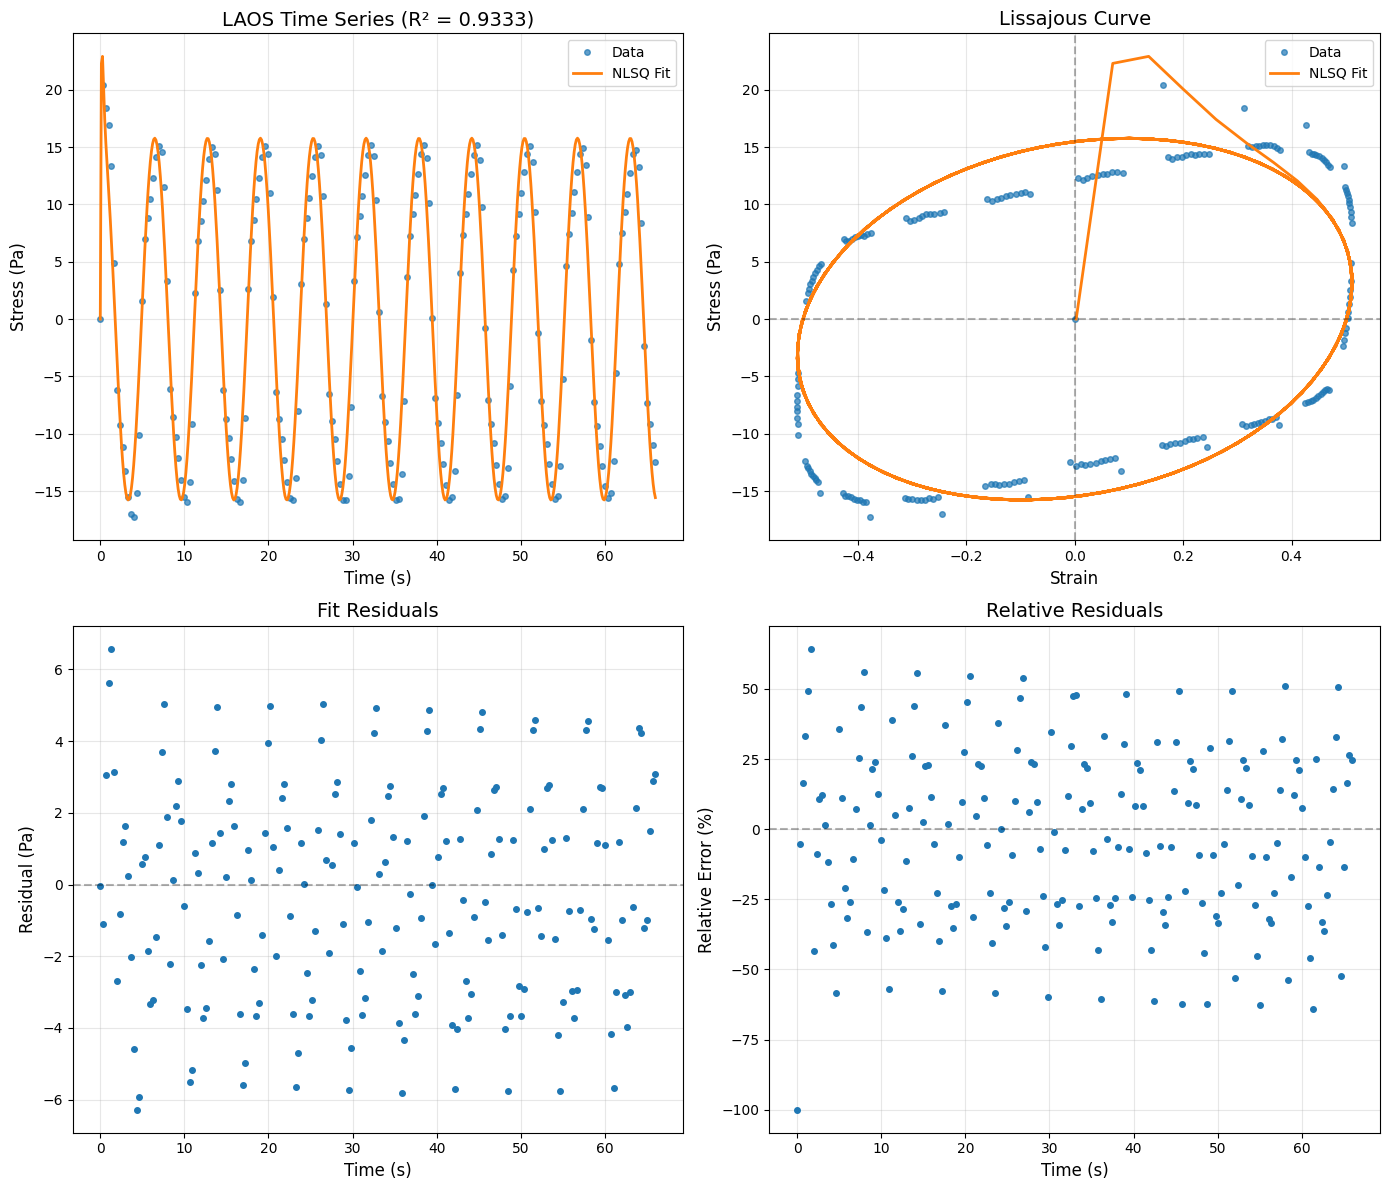

In [4]:
time_pred = jnp.linspace(time_data.min(), time_data.max(), 500)
stress_pred = model.predict(time_pred, test_mode='laos', gamma_0=gamma_0, omega=omega)
strain_pred = gamma_0 * jnp.sin(omega * time_pred)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12))

# Time series
ax1.plot(time_data, stress, 'o', label='Data', markersize=4, alpha=0.7)
ax1.plot(time_pred, stress_pred, '-', label='NLSQ Fit', linewidth=2)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Stress (Pa)', fontsize=12)
ax1.set_title(f'LAOS Time Series (R² = {metrics["R2"]:.4f})', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Lissajous comparison
ax2.plot(strain, stress, 'o', label='Data', markersize=4, alpha=0.7)
ax2.plot(strain_pred, stress_pred, '-', label='NLSQ Fit', linewidth=2)
ax2.set_xlabel('Strain', fontsize=12)
ax2.set_ylabel('Stress (Pa)', fontsize=12)
ax2.set_title('Lissajous Curve', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
ax2.axvline(0, color='k', linestyle='--', alpha=0.3)

# Residuals
stress_fit = model.predict(time_data, test_mode='laos', gamma_0=gamma_0, omega=omega)
residuals = stress - stress_fit
ax3.plot(time_data, residuals, 'o', markersize=4)
ax3.axhline(0, color='k', linestyle='--', alpha=0.3)
ax3.set_xlabel('Time (s)', fontsize=12)
ax3.set_ylabel('Residual (Pa)', fontsize=12)
ax3.set_title('Fit Residuals', fontsize=14)
ax3.grid(True, alpha=0.3)

# Relative error
rel_error = (stress - stress_fit) / (np.abs(stress) + 1e-10) * 100
ax4.plot(time_data, rel_error, 'o', markersize=4)
ax4.axhline(0, color='k', linestyle='--', alpha=0.3)
ax4.set_xlabel('Time (s)', fontsize=12)
ax4.set_ylabel('Relative Error (%)', fontsize=12)
ax4.set_title('Relative Residuals', fontsize=14)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

## Physical Analysis: Bridge Fraction Oscillation

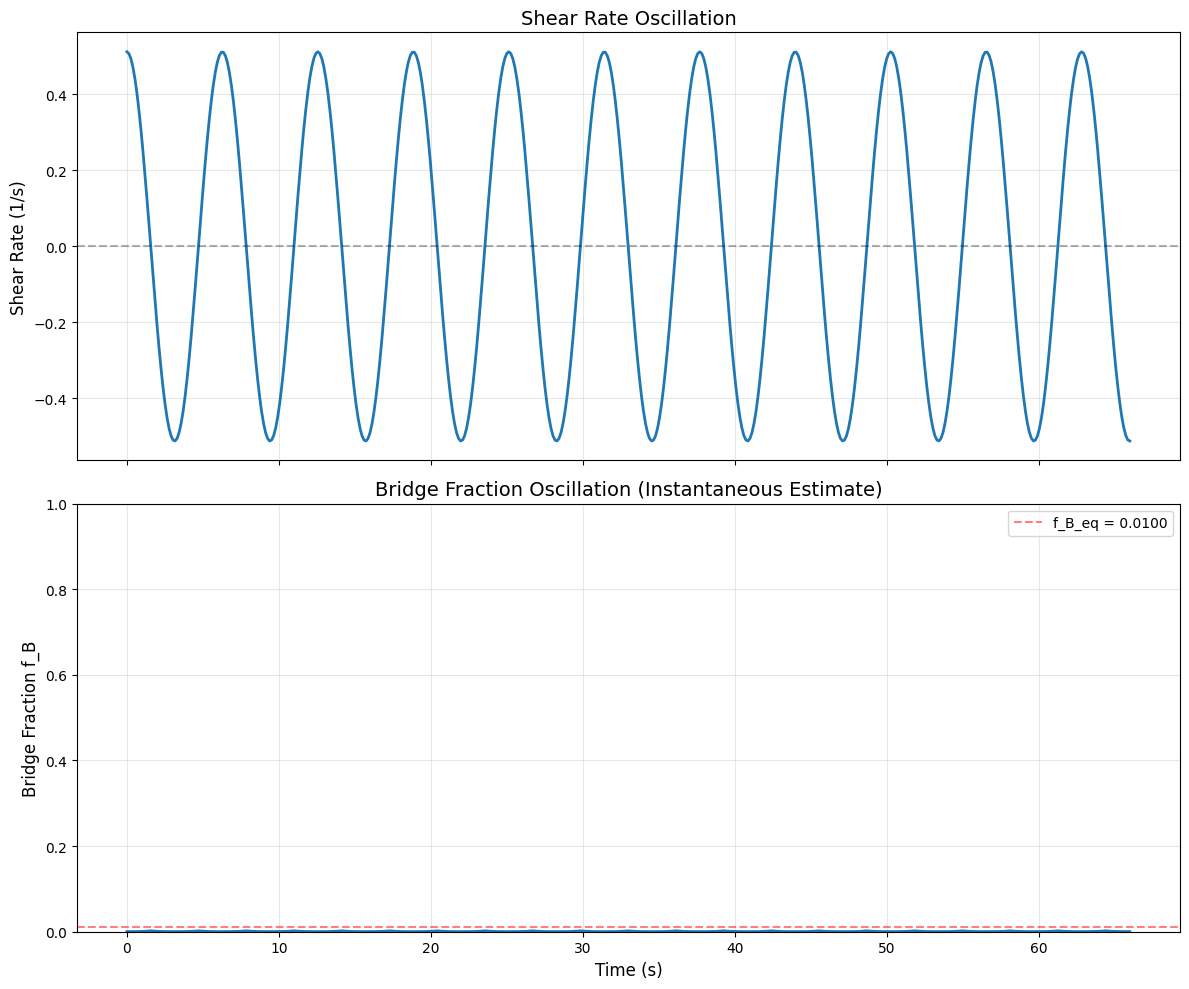


Bridge fraction oscillation:
  Mean f_B: 0.0007
  Min f_B: 0.0003
  Max f_B: 0.0021
  Amplitude: 0.0009
  Equilibrium f_B_eq: 0.0100


In [5]:
# Estimate bridge fraction oscillation
# Simplified: f_B responds to instantaneous shear rate
gamma_dot_pred = gamma_0 * omega * jnp.cos(omega * time_pred)
k_detach = jnp.exp(model.parameters.get_value('nu') * jnp.abs(gamma_dot_pred) * model.parameters.get_value('tau_b')) / model.parameters.get_value('tau_b')
k_attach = 1.0 / model.parameters.get_value('tau_a')
f_B_instantaneous = k_attach / (k_attach + k_detach)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Shear rate vs time
ax1.plot(time_pred, gamma_dot_pred, '-', linewidth=2)
ax1.axhline(0, color='k', linestyle='--', alpha=0.3)
ax1.set_ylabel('Shear Rate (1/s)', fontsize=12)
ax1.set_title('Shear Rate Oscillation', fontsize=14)
ax1.grid(True, alpha=0.3)

# Bridge fraction vs time
ax2.plot(time_pred, f_B_instantaneous, '-', linewidth=2)
ax2.axhline(model.parameters.get_value('f_B_eq'), color='r', linestyle='--', alpha=0.5, label=f'f_B_eq = {model.parameters.get_value('f_B_eq'):.4f}')
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Bridge Fraction f_B', fontsize=12)
ax2.set_title('Bridge Fraction Oscillation (Instantaneous Estimate)', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()
plt.close('all')

print(f"\nBridge fraction oscillation:")
print(f"  Mean f_B: {jnp.mean(f_B_instantaneous):.4f}")
print(f"  Min f_B: {jnp.min(f_B_instantaneous):.4f}")
print(f"  Max f_B: {jnp.max(f_B_instantaneous):.4f}")
print(f"  Amplitude: {(jnp.max(f_B_instantaneous) - jnp.min(f_B_instantaneous)) / 2:.4f}")
print(f"  Equilibrium f_B_eq: {model.parameters.get_value('f_B_eq'):.4f}")

## Physical Analysis: Fourier Harmonics

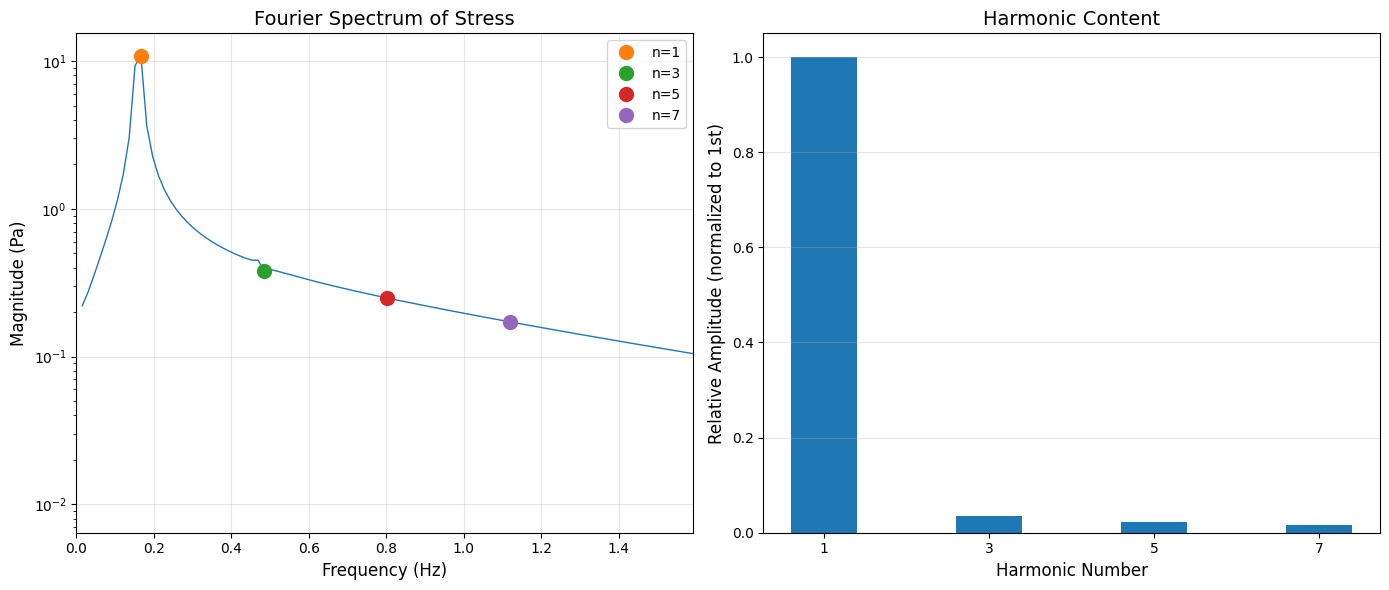


Harmonic analysis:
  Fundamental frequency: 0.1592 Hz
  Harmonic 1: 1.0813e+01 Pa (100.00% of fundamental)
  Harmonic 3: 3.8041e-01 Pa (3.52% of fundamental)
  Harmonic 5: 2.4930e-01 Pa (2.31% of fundamental)
  Harmonic 7: 1.7172e-01 Pa (1.59% of fundamental)

Nonlinearity metric I₃/I₁: 0.0352
  → Moderate nonlinearity


In [6]:
# FFT analysis of stress
from scipy.fft import fft, fftfreq

n = len(stress_pred)
dt = float(time_pred[1] - time_pred[0])
stress_fft = fft(stress_pred)
freqs = fftfreq(n, dt)

# Extract positive frequencies
positive_freqs = freqs > 0
freqs_pos = freqs[positive_freqs]
magnitude = np.abs(stress_fft[positive_freqs]) / n * 2  # Factor of 2 for positive frequencies

# Find harmonics
fundamental_freq = omega / (2 * np.pi)  # Hz
harmonic_indices = []
harmonic_mags = []
for n_harmonic in [1, 3, 5, 7]:
    target_freq = n_harmonic * fundamental_freq
    idx = np.argmin(np.abs(freqs_pos - target_freq))
    harmonic_indices.append(idx)
    harmonic_mags.append(magnitude[idx])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# FFT spectrum
ax1.semilogy(freqs_pos, magnitude, '-', linewidth=1)
for i, n_h in enumerate([1, 3, 5, 7]):
    ax1.plot(freqs_pos[harmonic_indices[i]], harmonic_mags[i], 'o', markersize=10, label=f'n={n_h}')
ax1.set_xlabel('Frequency (Hz)', fontsize=12)
ax1.set_ylabel('Magnitude (Pa)', fontsize=12)
ax1.set_title('Fourier Spectrum of Stress', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 10 * fundamental_freq])

# Harmonic amplitudes
harmonic_numbers = [1, 3, 5, 7]
relative_mags = [mag / harmonic_mags[0] for mag in harmonic_mags]
ax2.bar(harmonic_numbers, relative_mags, width=0.8)
ax2.set_xlabel('Harmonic Number', fontsize=12)
ax2.set_ylabel('Relative Amplitude (normalized to 1st)', fontsize=12)
ax2.set_title('Harmonic Content', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(harmonic_numbers)

plt.tight_layout()
plt.show()
plt.close('all')

print(f"\nHarmonic analysis:")
print(f"  Fundamental frequency: {fundamental_freq:.4f} Hz")
for i, n_h in enumerate(harmonic_numbers):
    print(f"  Harmonic {n_h}: {harmonic_mags[i]:.4e} Pa ({relative_mags[i]*100:.2f}% of fundamental)")

# Nonlinearity metric
I3_I1 = relative_mags[1]  # G'₃/G'₁
print(f"\nNonlinearity metric I₃/I₁: {I3_I1:.4f}")
if I3_I1 > 0.1:
    print("  → Strong nonlinearity detected")
elif I3_I1 > 0.01:
    print("  → Moderate nonlinearity")
else:
    print("  → Weak nonlinearity")

## Physical Analysis: Lissajous Shape

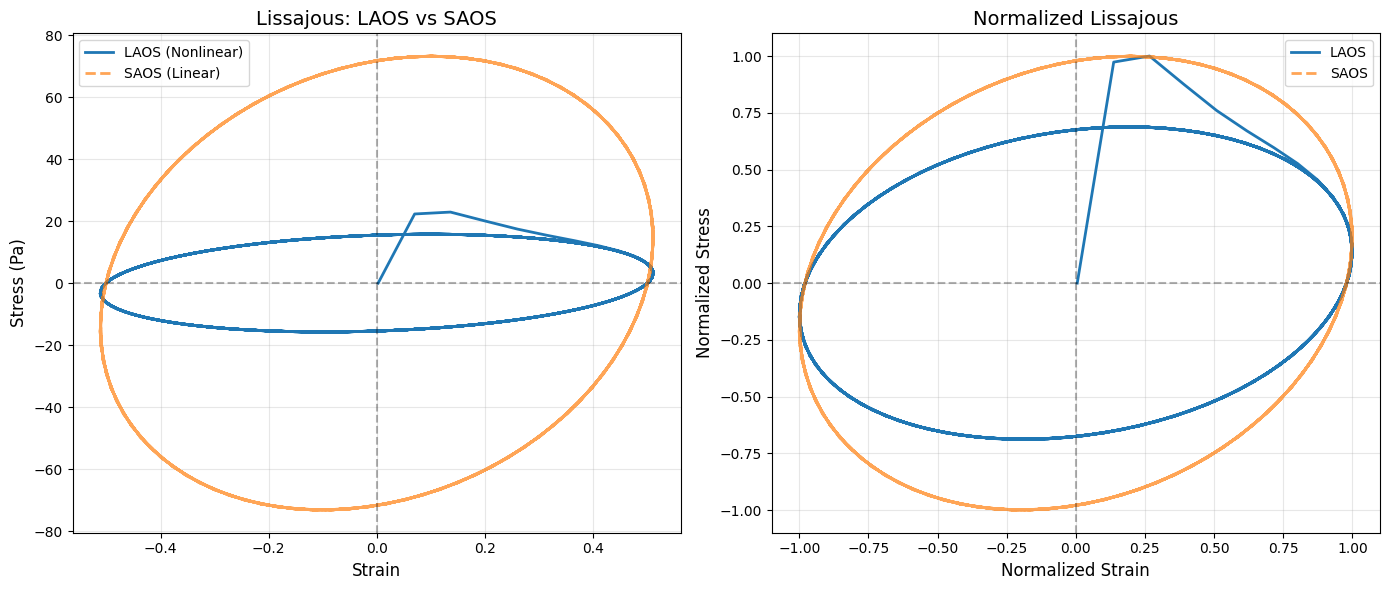


Lissajous shape analysis:
  SAOS G': 2.8307e+01 Pa
  SAOS G'': 1.4023e+02 Pa
  LAOS peak stress: 2.2901e+01 Pa
  SAOS peak stress: 7.3243e+01 Pa
  Softening ratio: 0.3127


In [7]:
# Compare with linear response
# Linear: σ = G' * γ₀ * sin(ωt) + G'' * γ₀ * cos(ωt)
G_eff = model.parameters.get_value('f_B_eq') * model.parameters.get_value('G')
G_prime_linear = G_eff * (omega * model.parameters.get_value('tau_b'))**2 / (1 + (omega * model.parameters.get_value('tau_b'))**2)
G_double_prime_linear = G_eff * (omega * model.parameters.get_value('tau_b')) / (1 + (omega * model.parameters.get_value('tau_b'))**2) + model.parameters.get_value('eta_s') * omega
stress_linear = G_prime_linear * gamma_0 * jnp.sin(omega * time_pred) + G_double_prime_linear * gamma_0 * jnp.cos(omega * time_pred)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Lissajous comparison
ax1.plot(strain_pred, stress_pred, '-', label='LAOS (Nonlinear)', linewidth=2)
ax1.plot(strain_pred, stress_linear, '--', label='SAOS (Linear)', linewidth=2, alpha=0.7)
ax1.set_xlabel('Strain', fontsize=12)
ax1.set_ylabel('Stress (Pa)', fontsize=12)
ax1.set_title('Lissajous: LAOS vs SAOS', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='k', linestyle='--', alpha=0.3)
ax1.axvline(0, color='k', linestyle='--', alpha=0.3)

# Normalized Lissajous
stress_pred_norm = stress_pred / jnp.max(jnp.abs(stress_pred))
stress_linear_norm = stress_linear / jnp.max(jnp.abs(stress_linear))
strain_pred_norm = strain_pred / gamma_0
ax2.plot(strain_pred_norm, stress_pred_norm, '-', label='LAOS', linewidth=2)
ax2.plot(strain_pred_norm, stress_linear_norm, '--', label='SAOS', linewidth=2, alpha=0.7)
ax2.set_xlabel('Normalized Strain', fontsize=12)
ax2.set_ylabel('Normalized Stress', fontsize=12)
ax2.set_title('Normalized Lissajous', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
ax2.axvline(0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

print(f"\nLissajous shape analysis:")
print(f"  SAOS G': {G_prime_linear:.4e} Pa")
print(f"  SAOS G'': {G_double_prime_linear:.4e} Pa")
peak_stress_laos = jnp.max(jnp.abs(stress_pred))
peak_stress_saos = jnp.max(jnp.abs(stress_linear))
print(f"  LAOS peak stress: {peak_stress_laos:.4e} Pa")
print(f"  SAOS peak stress: {peak_stress_saos:.4e} Pa")
print(f"  Softening ratio: {peak_stress_laos / peak_stress_saos:.4f}")

## Bayesian Inference

In [8]:
# CI mode: Skip Bayesian inference to avoid JIT compilation timeout
# Set CI_MODE=1 environment variable to skip
CI_MODE = os.environ.get("CI_MODE", "0") == "1"

# Configuration
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

if CI_MODE:
    print("CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)")
    print("To run Bayesian analysis, run without CI_MODE environment variable")
    # Create a placeholder result with current NLSQ parameters
    class BayesianResult:
        def __init__(self, model, param_names):
            self.posterior_samples = {name: np.array([model.parameters.get_value(name)] * NUM_SAMPLES) for name in param_names}
    bayes_result = BayesianResult(model, param_names)
    bayes_time = 0.0
else:
    print(f"Running NUTS with {NUM_CHAINS} chain(s)...")
    print(f"Warmup: {NUM_WARMUP} samples, Sampling: {NUM_SAMPLES} samples")
    
    start_time = time.time()
    bayes_result = model.fit_bayesian(
        time_data, stress,
        test_mode='laos',
        
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        seed=42
    )
    bayes_time = time.time() - start_time
    
    print(f"\nBayesian inference completed in {bayes_time:.1f} seconds")


CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)
To run Bayesian analysis, run without CI_MODE environment variable


## Convergence Diagnostics

In [9]:
# Skip convergence diagnostics in CI mode
if not CI_MODE:
    print_convergence_summary(bayes_result, param_names)
else:
    print("CI_MODE: Skipping convergence diagnostics")


CI_MODE: Skipping convergence diagnostics


## Parameter Comparison: NLSQ vs Bayesian

In [10]:
print_parameter_comparison(model, bayes_result.posterior_samples, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G      7.23e+04      7.23e+04  [7.23e+04, 7.23e+04]
          tau_b        0.2019        0.2019  [0.2019, 0.2019]
          tau_a         91.97         91.97  [91.97, 91.97]
             nu            20            20  [20, 20]
         f_B_eq          0.01          0.01  [0.01, 0.01]
          eta_s     1.592e-36     1.592e-36  [1.592e-36, 1.592e-36]


## ArviZ: Trace Plot

In [11]:
# Skip trace plot in CI mode
if not CI_MODE:
    idata = az.from_dict(posterior=bayes_result.posterior_samples)
    
    axes = az.plot_trace(idata, var_names=param_names, compact=False, backend_kwargs={'figsize': (12, 10)})
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    print("CI_MODE: Skipping trace plot")


CI_MODE: Skipping trace plot


## ArviZ: Posterior Distributions

In [12]:
# Skip ArviZ plot in CI mode
if not CI_MODE:
    fig = az.plot_posterior(idata, var_names=param_names, hdi_prob=0.95, backend_kwargs={'figsize': (12, 8)})
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    print("CI_MODE: Skipping ArviZ plot")


CI_MODE: Skipping ArviZ plot


## ArviZ: Pair Plot

In [13]:
# Skip pair plot in CI mode
if not CI_MODE:
    axes = az.plot_pair(
        idata,
        var_names=param_names,
        kind='kde',
        marginals=True,
        backend_kwargs={'figsize': (14, 14)}
    )
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    print("CI_MODE: Skipping pair plot")


CI_MODE: Skipping pair plot


## Posterior Predictive

In [ ]:
# CI mode: Skip slow posterior predictive (200 ODE solves)
if CI_MODE:
    print("CI_MODE: Skipping posterior predictive (200 predictions would take >300s)")
    # Use NLSQ fit for visualization instead
    pred_mean = model.predict(time_pred, test_mode='laos', gamma_0=gamma_0, omega=omega)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    ax1.plot(time_data, stress, 'o', label='Data', markersize=4, alpha=0.7, zorder=3)
    ax1.plot(time_pred, pred_mean, '-', label='NLSQ Fit', linewidth=2, zorder=2)
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel('Stress (Pa)', fontsize=12)
    ax1.set_title('LAOS (CI Mode)', fontsize=14)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(strain, stress, 'o', label='Data', markersize=4, alpha=0.7, zorder=3)
    ax2.plot(strain_pred, pred_mean, '-', label='NLSQ Fit', linewidth=2, zorder=2)
    ax2.set_xlabel('Strain', fontsize=12)
    ax2.set_ylabel('Stress (Pa)', fontsize=12)
    ax2.set_title('Lissajous (CI Mode)', fontsize=14)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
    ax2.axvline(0, color='k', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    posterior = bayes_result.posterior_samples
    n_draws = 200
    indices = np.random.choice(NUM_SAMPLES, size=n_draws, replace=False)

    predictions = []
    for i in indices:
        # Set parameters from posterior sample
        for name in param_names:
            model.parameters.set_value(name, float(posterior[name][i]))
        # Use predict method
        pred = model.predict(time_pred, test_mode='laos', gamma_0=gamma_0, omega=omega)
        predictions.append(np.array(pred))

    predictions = np.array(predictions)
    pred_mean = predictions.mean(axis=0)
    pred_lower = np.percentile(predictions, 2.5, axis=0)
    pred_upper = np.percentile(predictions, 97.5, axis=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Time series
    ax1.plot(time_data, stress, 'o', label='Data', markersize=4, alpha=0.7, zorder=3)
    ax1.plot(time_pred, pred_mean, '-', label='Posterior Mean', linewidth=2, zorder=2)
    ax1.fill_between(time_pred, pred_lower, pred_upper, alpha=0.3, label='95% Credible Interval', zorder=1)
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel('Stress (Pa)', fontsize=12)
    ax1.set_title('Posterior Predictive (Time Series)', fontsize=14)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Lissajous
    ax2.plot(strain, stress, 'o', label='Data', markersize=4, alpha=0.7, zorder=3)
    ax2.plot(strain_pred, pred_mean, '-', label='Posterior Mean', linewidth=2, zorder=2)
    ax2.set_xlabel('Strain', fontsize=12)
    ax2.set_ylabel('Stress (Pa)', fontsize=12)
    ax2.set_title('Posterior Predictive (Lissajous)', fontsize=14)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(0, color='k', linestyle='--', alpha=0.3)
    ax2.axvline(0, color='k', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.close()

## Physical Interpretation

In [15]:
print("\n=== Physical Interpretation ===")
print(f"\n1. Test Conditions:")
print(f"   - Strain amplitude γ₀: {gamma_0:.4f}")
print(f"   - Frequency ω: {omega:.2f} rad/s ({omega/(2*np.pi):.4f} Hz)")
print(f"   - Peak shear rate: {gamma_0 * omega:.4f} 1/s")
print(f"   - Period: {2*np.pi/omega:.4f} s")

print(f"\n2. Material Properties:")
print(f"   - Plateau modulus G: {model.parameters.get_value('G'):.4e} Pa")
print(f"   - Equilibrium bridge fraction: {model.parameters.get_value('f_B_eq'):.4f}")
print(f"   - Effective modulus (linear): {G_eff:.4e} Pa")

print(f"\n3. Bridge Fraction Dynamics:")
print(f"   - Mean f_B during LAOS: {jnp.mean(f_B_instantaneous):.4f}")
print(f"   - Min f_B: {jnp.min(f_B_instantaneous):.4f}")
print(f"   - Max f_B: {jnp.max(f_B_instantaneous):.4f}")
print(f"   - Oscillation amplitude: {(jnp.max(f_B_instantaneous) - jnp.min(f_B_instantaneous))/2:.4f}")
print(f"   - Reduction vs equilibrium: {(1 - jnp.mean(f_B_instantaneous)/model.parameters.get_value('f_B_eq'))*100:.2f}%")

print(f"\n4. Nonlinearity:")
print(f"   - I₃/I₁ ratio: {I3_I1:.4f}")
print(f"   - Strain softening: {(1 - peak_stress_laos/peak_stress_saos)*100:.2f}%")
print(f"   - Higher harmonics present: 3rd, 5th, 7th")

print(f"\n5. Bell Detachment:")
print(f"   - Nu parameter: {model.parameters.get_value('nu'):.4f}")
force_factor_max = jnp.exp(model.parameters.get_value('nu') * gamma_0 * omega * model.parameters.get_value('tau_b'))
print(f"   - Bell factor at peak shear rate: {force_factor_max:.4f}")
print(f"   - Detachment enhancement: {force_factor_max:.2f}x")

print(f"\n6. Timescale Comparison:")
print(f"   - Bridge detachment time tau_b: {model.parameters.get_value('tau_b'):.4e} s")
print(f"   - Oscillation period: {2*np.pi/omega:.4e} s")
print(f"   - Ratio (period/tau_b): {(2*np.pi/omega)/model.parameters.get_value('tau_b'):.4f}")
if (2*np.pi/omega) > 10 * model.parameters.get_value('tau_b'):
    print(f"   - f_B fully equilibrates within each cycle")
elif (2*np.pi/omega) > model.parameters.get_value('tau_b'):
    print(f"   - f_B partially equilibrates")
else:
    print(f"   - f_B cannot follow oscillation (inertial response)")


=== Physical Interpretation ===

1. Test Conditions:
   - Strain amplitude γ₀: 0.5120
   - Frequency ω: 1.00 rad/s (0.1592 Hz)
   - Peak shear rate: 0.5120 1/s
   - Period: 6.2832 s

2. Material Properties:
   - Plateau modulus G: 7.2303e+04 Pa
   - Equilibrium bridge fraction: 0.0100
   - Effective modulus (linear): 7.2303e+02 Pa

3. Bridge Fraction Dynamics:
   - Mean f_B during LAOS: 0.0007
   - Min f_B: 0.0003
   - Max f_B: 0.0021
   - Oscillation amplitude: 0.0009
   - Reduction vs equilibrium: 92.72%

4. Nonlinearity:
   - I₃/I₁ ratio: 0.0352
   - Strain softening: 68.73%
   - Higher harmonics present: 3rd, 5th, 7th

5. Bell Detachment:
   - Nu parameter: 20.0000
   - Bell factor at peak shear rate: 7.9001
   - Detachment enhancement: 7.90x

6. Timescale Comparison:
   - Bridge detachment time tau_b: 2.0185e-01 s
   - Oscillation period: 6.2832e+00 s
   - Ratio (period/tau_b): 31.1272
   - f_B fully equilibrates within each cycle


## Save Results

In [16]:
save_tnt_results(model, bayes_result, "loop_bridge", "laos", param_names)
print("Results saved to reference_outputs/tnt/loop_bridge_laos_results.npz")

Results saved to /Users/b80985/Projects/rheojax/examples/tnt/../utils/../outputs/tnt/loop_bridge/laos/
  nlsq_params_laos.json: 6 parameters
  posterior_laos.json: 500 draws
Results saved to reference_outputs/tnt/loop_bridge_laos_results.npz


## Key Takeaways

1. **Nonlinear Response**: LAOS drives bridge fraction oscillation → strain-dependent modulus

2. **Intracycle Dynamics**: f_B decreases at high shear rate, recovers at low shear rate

3. **Harmonic Distortion**: Nonlinear stress contains odd harmonics (3ω, 5ω, ...) quantifying departure from linearity

4. **Strain Softening**: Effective modulus decreases with strain amplitude due to bridge depletion

5. **Bell Physics**: Force-enhanced detachment (nu > 0) essential for capturing LAOS nonlinearity

6. **Lissajous Curves**: Non-elliptical shape reveals intracycle structural changes

7. **Timescale Control**: If oscillation period >> tau_b, f_B equilibrates; if period ~ tau_b, partial response